## Exp1：Feed Forward Neural Network
使用pytorch或者tensorflow写一个前馈神经网络，用于近似正弦函数y=sin(x)，𝑥∈[0,4𝜋)，研究网络深度、学习率、网络宽度、激活函数对模型性能的影响

SA21229033_徐宽_第一次实验 

### 1. 基本实现过程

In [1]:
import torch
from torch import nn
import numpy as np
import time
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set random seed
def setup_seed(seed):
     torch.manual_seed(seed)
#      torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
#      random.seed(seed)
#      torch.backends.cudnn.deterministic = True

In [2]:
# Data preparation
num_inputs = 1
num_examples = 10000
rate_test = 0.3
x_features = torch.tensor(np.random.rand(num_examples, num_inputs)*4*torch.pi, dtype=torch.float)
y_labels = torch.sin(x_features)
# y_labels += torch.tensor(np.random.normal(0, 0.01, size=y_labels.size()), dtype=torch.float)
# Train_set
trainfeatures = x_features[round(num_examples*rate_test):]
trainlabels = y_labels[round(num_examples*rate_test):]
print(trainfeatures.shape)
# Test_set
testfeatures = x_features[:round(num_examples*rate_test)]
testlabels = y_labels[:round(num_examples*rate_test)]
print(testfeatures.shape)

torch.Size([7000, 1])
torch.Size([3000, 1])


In [3]:
# 读取数据
batch_size = 100
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(trainfeatures, trainlabels)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(
    dataset=dataset,  # torch TensorDataset format
    batch_size=batch_size,  # mini batch size
    shuffle=True,  # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0,  # 多线程来读数据， 注意在Windows下需要设置为0
)
# 将测试数据的特征和标签组合
dataset = Data.TensorDataset(testfeatures, testlabels)
# 把 dataset 放入 DataLoader
test_iter = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,  
    num_workers=0,  
)

In [4]:
# Fully connected neural network
class XKnet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layers, activate):
        super(XKnet, self).__init__()
        self.hidden_layers = hidden_layers
        self.activate_fcs = {
            'relu': nn.ReLU(),
            'prelu': nn.PReLU(),
            'elu': nn.ELU(),
            'tanh': nn.Tanh()
        }
        self.fc_list = nn.ModuleList()
        self.fc_list.append(nn.Linear(input_size, hidden_size))
        for i in range(self.hidden_layers):
            # self.fc_list.append(nn.ReLU())
            self.fc_list.append(self.activate_fcs.get(activate))
            self.fc_list.append(nn.Linear(hidden_size, hidden_size))
        # self.fc_list.append(nn.ReLU())
        self.fc_list.append(self.activate_fcs.get(activate))
        self.fc_list.append(nn.Linear(hidden_size, 1))

    def forward(self, x):
        for fc in self.fc_list:
            x = fc(x)
        return x

In [5]:
setup_seed(20211030)

# Hyper-parameters
input_size = 1
hidden_size = 64
hidden_layers = 4
num_epochs = 30
batch_size = 100
learning_rate = 0.001
activate = 'relu'

# Instantiation the model
xknet = XKnet(input_size, hidden_size, hidden_layers, activate)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(xknet.parameters(), lr=learning_rate)

In [6]:
# Train the model
t = time.time()
train_loss, test_loss = [], []
for epoch in range(num_epochs):
    for X, y in train_iter:  # x和y分别是小批量样本的特征和标签
        optimizer.zero_grad()
        y_hat = xknet(X)
        loss = criterion(y, y_hat)
        loss.backward()
        optimizer.step()
    train_loss.append(criterion(xknet(trainfeatures), trainlabels).item())
    test_loss.append(criterion(xknet(testfeatures), testlabels).item())
    if (epoch+1) % 5 == 0:
        print('Epoch [{}/{}], train_loss: {:.6f}, test_loss: {:.6f}'
              .format(epoch+1, num_epochs, train_loss[epoch], test_loss[epoch]))
print('run_time: ', time.time()-t, 's')

Epoch [5/30], train_loss: 0.023141, test_loss: 0.024568
Epoch [10/30], train_loss: 0.002174, test_loss: 0.001978
Epoch [15/30], train_loss: 0.001319, test_loss: 0.001306
Epoch [20/30], train_loss: 0.000454, test_loss: 0.000469
Epoch [25/30], train_loss: 0.005819, test_loss: 0.006147
Epoch [30/30], train_loss: 0.000148, test_loss: 0.000152
run_time:  4.349714517593384 s


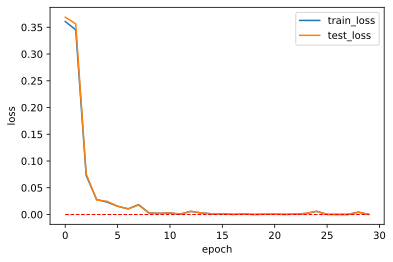

In [7]:
# plot loss curve
x = range(num_epochs)
plt.plot(x, train_loss, label="train_loss", linewidth=1.5)
plt.plot(x, test_loss, label="test_loss", linewidth=1.5)
plt.plot(x, np.zeros(len(x)), 'red', linestyle='--', linewidth=1)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

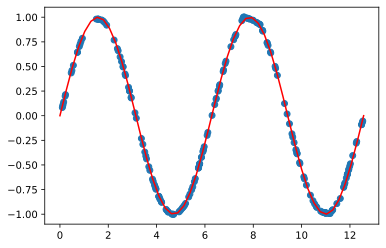

In [8]:
# plot prediction results
x = x_features[:200]
y = xknet(x).detach().numpy().reshape(1,-1)[0].tolist()
plt.scatter(x, y)

x = np.linspace(0, 4*np.pi)
plt.plot(x,np.sin(x), 'red')
plt.show()

### 2. 网络深度对模型性能的影响

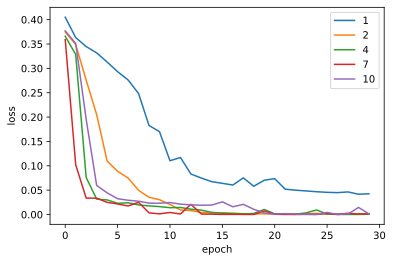

In [9]:
setup_seed(20211030)

# Hyper-parameters
input_size = 1
hidden_size = 64
# hidden_layers = 4
num_epochs = 30
batch_size = 100
learning_rate = 0.001
activate = 'relu'

time_list = []
x = range(num_epochs)
for hidden_layers in [1,2,4,7,10]:
    # Instantiation the model
    xknet = XKnet(input_size, hidden_size, hidden_layers, activate)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(xknet.parameters(), lr=learning_rate)

    # Train the model
    t = time.time()
    train_loss, test_loss = [], []
    for epoch in range(num_epochs):
        for X, y in train_iter:  # x和y分别是小批量样本的特征和标签
            optimizer.zero_grad()
            y_hat = xknet(X)
            loss = criterion(y, y_hat)
            loss.backward()
            optimizer.step()
        train_loss.append(criterion(xknet(trainfeatures), trainlabels).item())
        test_loss.append(criterion(xknet(testfeatures), testlabels).item())
        
    time_list.append(time.time()-t)
    plt.plot(x, test_loss, label=str(hidden_layers), linewidth=1.5)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

由上图可以看出：  
* 隐藏层只有一层的时候，loss达到0.1左右就很难继续下降了，这说明此时网络的表达能力非常有限，还不足以较为精确地逼近正弦函数。  
* 当隐藏层数量达到2层时，loss下降得慢一些，但是到后期已经很接近0了，说明此时已经具备较好的逼近能力。  
* 当隐藏层数量达到4层，7层甚至10层时，loss继续降低，表示网络的拟合能力继续增强，但是增速放缓。  

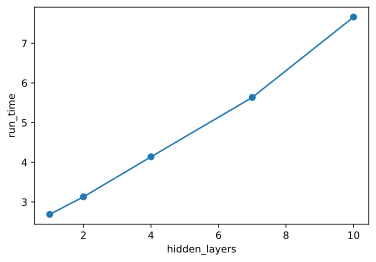

In [10]:
plt.scatter([1,2,4,7,10],time_list)
plt.plot([1,2,4,7,10],time_list)
plt.xlabel('hidden_layers')
plt.ylabel('run_time')
plt.show()

从运行时间上看，网络深度的增加将会带来运行时间的同比例增加，它们是近乎线性的。

### 3. 网络宽度对模型性能的影响

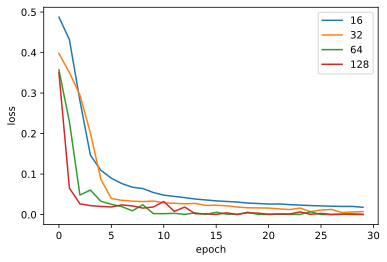

In [11]:
setup_seed(20211030)

# Hyper-parameters
input_size = 1
# hidden_size = 64
hidden_layers = 4
num_epochs = 30
batch_size = 100
learning_rate = 0.001
activate = 'relu'

time_list = []
x = range(num_epochs)
for hidden_size in [16,32,64,128]:
    # Instantiation the model
    xknet = XKnet(input_size, hidden_size, hidden_layers, activate)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(xknet.parameters(), lr=learning_rate)

    # Train the model
    t = time.time()
    train_loss, test_loss = [], []
    for epoch in range(num_epochs):
        for X, y in train_iter:  # x和y分别是小批量样本的特征和标签
            optimizer.zero_grad()
            y_hat = xknet(X)
            loss = criterion(y, y_hat)
            loss.backward()
            optimizer.step()
        train_loss.append(criterion(xknet(trainfeatures), trainlabels).item())
        test_loss.append(criterion(xknet(testfeatures), testlabels).item())
        
    time_list.append(time.time()-t)
    plt.plot(x, test_loss, label=str(hidden_size), linewidth=1.5)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

可以看出在迭代前期，网络宽度越大，模型的精度越高，但是15代之后就基本没多大区别了，说明网络宽度对于模型的精度而言影响不大

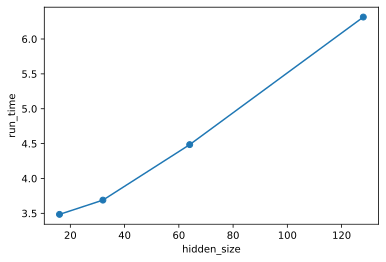

In [12]:
plt.scatter([16,32,64,128],time_list)
plt.plot([16,32,64,128],time_list)
plt.xlabel('hidden_size')
plt.ylabel('run_time')
plt.show()

而运行时间也几乎是随网络宽度线性增长的

### 4. 学习率对模型性能的影响

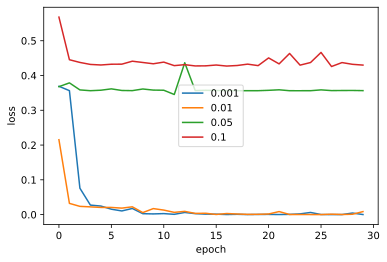

In [13]:
setup_seed(20211030)

# Hyper-parameters
input_size = 1
hidden_size = 64
hidden_layers = 4
num_epochs = 30
batch_size = 100
# learning_rate = 0.001
activate = 'relu'

time_list = []
x = range(num_epochs)
for learning_rate in [0.001, 0.01, 0.05, 0.1]:
    # Instantiation the model
    xknet = XKnet(input_size, hidden_size, hidden_layers, activate)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(xknet.parameters(), lr=learning_rate)

    # Train the model
    t = time.time()
    train_loss, test_loss = [], []
    for epoch in range(num_epochs):
        for X, y in train_iter:  # x和y分别是小批量样本的特征和标签
            optimizer.zero_grad()
            y_hat = xknet(X)
            loss = criterion(y, y_hat)
            loss.backward()
            optimizer.step()
        train_loss.append(criterion(xknet(trainfeatures), trainlabels).item())
        test_loss.append(criterion(xknet(testfeatures), testlabels).item())
        
    time_list.append(time.time()-t)
    plt.plot(x, test_loss, label=str(learning_rate), linewidth=1.5)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

根据上图我们可以发现：  
* 当学习率取为0.01或0.001的时候，训练都是正常的，loss曲线一开始下降较快，慢慢达到稳定；  
* 当学习率取为0.05或0.1的时候，loss曲线并不下降，而是反复震荡，说明此时学习率过大，网络不收敛。

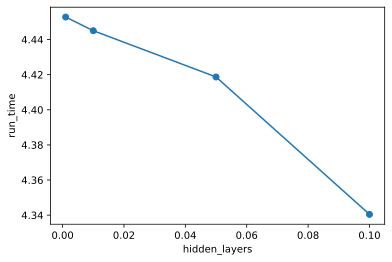

In [14]:
plt.scatter([0.001, 0.01, 0.05, 0.1],time_list)
plt.plot([0.001, 0.01, 0.05, 0.1],time_list)
plt.xlabel('hidden_layers')
plt.ylabel('run_time')
plt.show()

看起来，学习率越大，运行时间越短，或许是由于步子迈的长，就优化得快，但是实际上总的来看，极差很小，说明学习率对于程序的运行时间并没有太大的影响。

### 5. 激活函数对模型性能的影响  

运行时间：
relu: 3.37 s
prelu: 3.44 s
elu: 3.92 s
tanh: 3.22 s


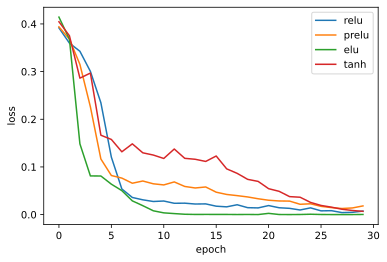

In [15]:
setup_seed(20211030)

# Hyper-parameters
input_size = 1
hidden_size = 64
hidden_layers = 2
num_epochs = 30
batch_size = 100
learning_rate = 0.001

time_list = []
x = range(num_epochs)
print('运行时间：')
for activate in ['relu', 'prelu', 'elu', 'tanh']:
    # Instantiation the model
    xknet = XKnet(input_size, hidden_size, hidden_layers, activate)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(xknet.parameters(), lr=learning_rate)

    # Train the model
    t = time.time()
    train_loss, test_loss = [], []
    for epoch in range(num_epochs):
        for X, y in train_iter:  # x和y分别是小批量样本的特征和标签
            optimizer.zero_grad()
            y_hat = xknet(X)
            loss = criterion(y, y_hat)
            loss.backward()
            optimizer.step()
        train_loss.append(criterion(xknet(trainfeatures), trainlabels).item())
        test_loss.append(criterion(xknet(testfeatures), testlabels).item())
        
    print(activate+':', round(time.time()-t,2), 's')
    plt.plot(x, test_loss, label=activate, linewidth=1.5)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

不难看出，不同的激活函数对于计算速度影响不大，但是对于模型迭代过程的loss曲线有一定的影响：  
* 表现最佳的是 ELU 函数，ReLU 和 PReLU 次之，Tanh 明显要逊色一些。